In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split
import copy
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [5]:
def standard_scalar_normalize(data_train, data_test): 
    scaler = StandardScaler()
    scaler.fit(data_train)
    normal_data_train = scaler.transform(data_train)
    normal_data_test = scaler.transform(data_test)
    return normal_data_train,normal_data_test

In [9]:
def quantile_transform(data_train, data_test):
    scaler = QuantileTransformer(random_state=0)
    scaled_data_train = scaler.fit_transform(data_train)
    scaled_data_test = scaler.transform(data_test)
    return scaled_data_train, scaled_data_test

In [10]:
def data_processed():
    '''
    Used to read & normalize processed test and train data
    '''
    data_train=pd.read_csv("data/2022-02-07_LOANS_TRAIN.csv")
    data_test=pd.read_csv("data/2022-02-07_LOANS_TEST.csv")
    y_train=data_train['loan_status']
    data_train.drop(columns=['loan_status', 'id', 'issue_d_in_months', 'issue_d_year', 'zip_state_match', 
                               'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
                               'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
                               'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                               'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
                               'WI', 'WV', 'WY'], inplace=True)
    
    data_test.drop(columns=['id', 'issue_d_in_months', 'issue_d_year', 'zip_state_match', 
                           'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
                           'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
                           'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                           'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
                           'WI', 'WV', 'WY'], inplace=True)
    
    normal_data_train,normal_data_test=standard_scalar_normalize(data_train,data_test)
    scaled_data_train, scaled_data_test = quantile_transform(normal_data_train, normal_data_test)
    return normal_data_train,normal_data_test,y_train

def AUC_score(y_ground_truth,y_predicted_probability):
    return roc_auc_score(y_ground_truth, y_predicted_probability)


In [11]:
X_train_full,X_test,Y_train_full=data_processed()
X_train, X_val, Y_train, Y_val = train_test_split(X_train_full, Y_train_full, train_size=0.80, random_state=42)

## We use class balancing or sample weighting for all the models, so no need for oversampling. See gc_ensemble_trees for oversampling code

## Gradient Boosting Classifier

In [12]:
gb_clf = GradientBoostingClassifier(max_depth=3, n_estimators=250, random_state=0)
gb_clf.fit(X_train, Y_train, sample_weight=copy.deepcopy(Y_train)*4 + 1)
Y_train_pred_gb=gb_clf.predict(X_train)
Y_val_pred_gb=gb_clf.predict(X_val)
Y_val_pred_prob_gb=gb_clf.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_gb)

0.689499088444349

In [13]:
Y_train_pred_prob_gb=gb_clf.predict_proba(X_train)[:,1]


In [14]:
confusion_matrix(Y_val,Y_val_pred_gb)

array([[ 2514, 30834],
       [   82,  6020]])

In [15]:
np.std(Y_val_pred_prob_gb)

0.14591565518288074

## LGBM Classifier

In [16]:
lgbm_clf = LGBMClassifier(class_weight='balanced', max_depth=11, min_child_samples=60, n_estimators=80)
lgbm_clf.fit(X_train, Y_train)
Y_train_pred_lgbm=lgbm_clf.predict(X_train)
Y_val_pred_lgbm=lgbm_clf.predict(X_val)
Y_val_pred_prob_lgbm=lgbm_clf.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_lgbm)

0.6915276501544827

In [17]:
Y_train_pred_prob_lgbm=lgbm_clf.predict_proba(X_train)[:,1]


In [18]:
confusion_matrix(Y_val,Y_val_pred_lgbm)

array([[20915, 12433],
       [ 2147,  3955]])

In [19]:
np.std(Y_val_pred_prob_lgbm)

0.1688596771713375

In [20]:
lgbm_clf2 = LGBMClassifier(class_weight='balanced', max_depth=5, min_child_samples=75, n_estimators=120)
lgbm_clf2.fit(X_train, Y_train)
Y_train_pred_lgbm2=lgbm_clf2.predict(X_train)
Y_val_pred_lgbm2=lgbm_clf2.predict(X_val)
Y_val_pred_prob_lgbm2=lgbm_clf2.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_lgbm2)

0.6921475396449948

In [21]:
Y_train_pred_prob_lgbm2=lgbm_clf2.predict_proba(X_train)[:,1]


In [22]:
confusion_matrix(Y_val,Y_val_pred_lgbm2)

array([[21066, 12282],
       [ 2170,  3932]])

## Random Forest Classifier 

In [23]:
rf_clf = RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=25, n_estimators=400)
rf_clf.fit(X_train, Y_train)
Y_train_pred_rf=rf_clf.predict(X_train)
Y_val_pred_rf=rf_clf.predict(X_val)
Y_val_pred_prob_rf=rf_clf.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_rf)

0.6895619024974144

In [24]:
Y_train_pred_prob_rf=rf_clf.predict_proba(X_train)[:,1]


In [25]:
confusion_matrix(Y_val,Y_val_pred_rf)

array([[25528,  7820],
       [ 3156,  2946]])

In [26]:
np.std(Y_val_pred_prob_rf)

0.15076759764574046

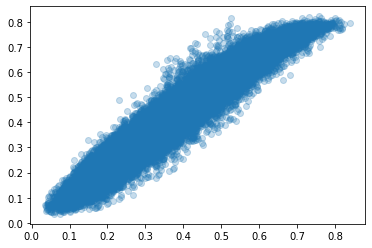

In [27]:
plt.scatter(Y_val_pred_prob_rf, Y_val_pred_prob_lgbm, alpha=0.25)


## Use average voting

In [29]:
Y_average = np.mean([Y_val_pred_prob_lgbm,Y_val_pred_prob_rf,Y_val_pred_prob_gb, Y_val_pred_prob_lgbm2], axis=0)

print(AUC_score(Y_val,Y_average))

Y_average[Y_average>=0.5] = 1
Y_average[Y_average<0.5] = 0
confusion_matrix(Y_val,Y_average)

0.6927631537305494


array([[15955, 17393],
       [ 1340,  4762]])

## Output to submission

In [30]:
gb_clf_full = GradientBoostingClassifier(max_depth=3, n_estimators=250, random_state=0)
gb_clf_full.fit(X_train_full, Y_train_full, sample_weight=copy.deepcopy(Y_train_full)*4 + 1)
Y_test_pred_prob_gb=gb_clf_full.predict_proba(X_test)[:,1]


lgbm_clf_full = LGBMClassifier(class_weight='balanced', max_depth=11, min_child_samples=60, n_estimators=80)
lgbm_clf_full.fit(X_train_full, Y_train_full)
Y_test_pred_prob_lgbm=lgbm_clf_full.predict_proba(X_test)[:,1]

lgbm_clf_full2 = LGBMClassifier(class_weight='balanced', max_depth=5, min_child_samples=75, n_estimators=120)
lgbm_clf_full2.fit(X_train_full, Y_train_full)
Y_test_pred_prob_lgbm2=lgbm_clf_full2.predict_proba(X_test)[:,1]


rf_clf_full = RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=25, n_estimators=400)
rf_clf_full.fit(X_train_full, Y_train_full)
Y_test_pred_prob_rf=rf_clf_full.predict_proba(X_test)[:,1]

test_probs = [Y_test_pred_prob_lgbm,Y_test_pred_prob_rf, Y_test_pred_prob_gb, Y_test_pred_prob_lgbm2]


In [31]:
def to_submission(ids, y_test_predicted_probability):
    y_test=pd.DataFrame(y_test_predicted_probability,columns=['loan_status'], index=ids)
    y_test.index.name = 'id'
    y_test.to_csv('data/submission.csv')
    return

Y_test_average = np.mean(test_probs, axis=0)
to_submission(pd.read_csv("data/2022-02-07_LOANS_TEST.csv")['id'].values, Y_test_average)